# Batch Gradient Descent (BGD) vs. Stochastic Gradient Descent (SGD) vs. Mini-batch Gradient Descent (MGD)  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [2]:
# the learning set

# a system with 100 samples, 1 feature
m, n = 100, 2

# normally we will have an eccess of 1 feature for regularization etc.
X = np.random.rand(m * n).reshape(m, n)
X_b = np.c_[
    np.ones((m, 1)),
    X
]
y = 4 + 3 * X.mean(axis=1).reshape(-1, 1) + np.random.randn(100, 1)


The normal equation:

$\hat{\theta}=(X^{T} X)^{-1} X^T y$

In [3]:
# get the optimal theta with the normal equation
def normal_equation(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    return np.linalg.pinv(X.T @ X) @ X.T @ y

theta_best = normal_equation(X_b, y)
theta_best

array([[3.22599667],
       [2.1431434 ],
       [2.45064222]])

## Cost Function: Mean Absolute Error (MAE)

The book uses mean squared error - but I like MAE, it makes more intuitive sense.

$MAE(\theta) = \frac{1}{m}\sum_{i=1}^{m}|(\theta^T x^{(i)} - y^{(i)})|$

In [4]:
def mean_absolute_error(
    theta: np.ndarray, X_b: np.ndarray, y: np.ndarray
    ) -> float:
    return np.sum(np.abs((X_b @ theta) - y)) / X_b.shape[0]

mean_absolute_error(theta_best, X_b, y)

0.7939379349417277

## Batch Gradient Descent

Partial derivative for a single $\theta_j$ i.e. _how much will the cost function change if you change $\theta_j$ a little bit_

$\frac{\delta}{\delta\theta_j}MAE(\theta)=\frac{2}{m}\sum_{i=1}^{m}(\theta^T x^{(i)} - y^{(i)})x^{(i)}_j$

For the whole batch:

$\triangledown_{\theta}MAE(\theta) = \frac{2}{m} X^T (X\theta - y)$ 

A gradient descent step with learning rate $\eta$:

$\theta^{(next step)} = \theta - \eta \triangledown_{\theta}MAE(\theta)$

> 🤪 Obvs I really like latex renderings on the notebook

In [5]:
def batch_gradient_descent(
    X_b: np.ndarray,
    y: np.ndarray,
    eta=0.1,
    n_iterations=1000,
    theta_start=None,
    tol=.001
    ):
    
    m, n = X_b.shape
    if theta_start is None:
        theta = np.random.randn(n, 1)
    else:
        theta = theta_start.copy()
    cost_function = {
        0: (theta, mean_absolute_error(theta, X_b, y))
    }
    
    for iteration in range(n_iterations):
        gradients = 2/m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients

        # append results
        score = mean_absolute_error(theta, X_b, y)
        cost_function[iteration+1] = (theta, score)

        if (np.abs(score - cost_function[iteration][1]) < tol):
            break


    return cost_function

_ = batch_gradient_descent(X_b, y)

## Stochastic Gradient Descent

- picks a random instance in the training set at every step and computes the
    gradients based only on that single instance
- much less regular than BGD, bounces around, never settle at minimum, 
    final parameters are good but not optimal, greater chance at escaping 
    local optima
- strategy to improve solution: gradually reduce learning rate using a *learning schedule*
- how to reduce learning rate?
    - too quickly: may get stuck in local mininum
    - too slowly: may jump around the minimum for a long time + suboptimal solution

Since we're calculating for a single random sample, we remove the $\frac{1}{m}$ term:

$\frac{\triangledown_{\theta}MAE(\theta)}{m} = 2 \times X^T (X\theta - y)$ 


In [6]:
def stochastic_gradient_descent(
    X_b: np.ndarray,
    y: np.ndarray,
    n_epochs=50,
    t0 = 5,
    t1 = 50,
    theta_start = None,
    tol=.001
    ):
    
    def learning_schedule(t): 
        return t0 / (t+t1)

    m, n = X_b.shape
    
    if theta_start is None:
        theta = np.random.randn(n, 1)
    else:
        theta = theta_start.copy()
    
    cost_function = {
        0: (theta, mean_absolute_error(theta, X_b, y))
    }

    for epoch in range(n_epochs):
        for i in range(m):
            random_idx = np.random.randint(m)
            xi = X_b[random_idx: random_idx+1, :]
            yi = y[random_idx: random_idx+1]
            gradients = 2 * xi.T @ (xi @ theta - yi)
            eta = learning_schedule(epoch * m + i)
            theta = theta - eta * gradients

        # append results
        score = mean_absolute_error(theta, X_b, y)
        cost_function[epoch+1] = (theta, score)
        
        if (np.abs(score - cost_function[epoch][1]) < tol):
            break

    return cost_function

_ = stochastic_gradient_descent(X_b, y)

## Mini-batch Gradient Descent

My implementation is simply to remove the inner loop of SGD, and sample mini-batches
instead.

The user can also set the size of the batch in percentage.

We were expecting this method to be less eratic, but as can be seen in its path in the parameter
space - its pretty wild. 

Not sure if I got this thing right - but could be a good research project to read
up on the state of the art.

In [7]:
def minibatch_gradient_descent(
    X_b: np.ndarray,
    y: np.ndarray,
    n_epochs=50,
    t0 = 5,
    t1 = 50,
    theta_start = None,
    tol=.001,
    batch_size=.1
    ):
    
    def learning_schedule(t): 
        return t0 / (t+t1)
    m, n = X_b.shape
    batch_size_= int(batch_size * m)

    if theta_start is None:
        theta = np.random.randn(n, 1)
    else:
        theta = theta_start.copy()
    
    cost_function = {
        0: (theta, mean_absolute_error(theta, X_b, y))
    }

    for epoch in range(n_epochs):
        random_idx = np.random.choice(range(m), batch_size_)
        Xi = X_b[random_idx, :]
        yi = y[random_idx, :]
        gradients = 2 * Xi.T @ (Xi @ theta - yi)
        eta = learning_schedule(epoch * m + epoch)
        theta = theta - eta * gradients

        # append results
        score = mean_absolute_error(theta, X_b, y)
        cost_function[epoch+1] = (theta, score)
        
        if (np.abs(score - cost_function[epoch][1]) < tol):
            break

    return cost_function

_ = minibatch_gradient_descent(X_b, y)

## The Parameter Space

In [8]:
from sklearn.decomposition import PCA

In [9]:
n_iterations = 100
theta_start = np.random.randn(n+1, 1)
tol = 0
bgd_regression = batch_gradient_descent(X_b, y, theta_start=theta_start, tol=tol, n_iterations=n_iterations)
sgd_regression = stochastic_gradient_descent(X_b, y, theta_start=theta_start, tol=tol, n_epochs=n_iterations)
mgd_regression = minibatch_gradient_descent(X_b, y, theta_start=theta_start, tol=tol, n_epochs=n_iterations)

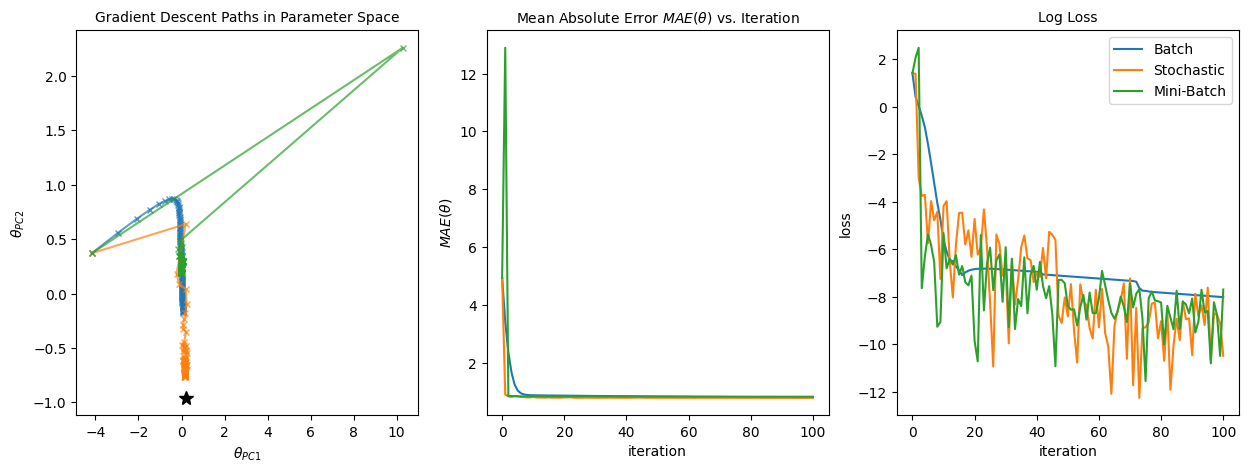

In [10]:
experiments = [
    ("Batch", bgd_regression), 
    ("Stochastic", sgd_regression),
    ("Mini-Batch", mgd_regression)
]
ps_len = [
    len(exp[1]) for exp in experiments
]
parameter_spaces = [
    np.r_[[res[0].T for it, res in exp[1].items()]].reshape(len(exp[1]), n+1)
    for exp in experiments
]

# convert parameter space to 2D so we can visualize
pca = PCA(n_components=2)
ps_2d = pca.fit_transform(np.r_[tuple(parameter_spaces)])
theta_best_2d = pca.transform(theta_best.T)

# 3 - parameter space, log loss and MSE
fig, ax = plt.subplots(1, 3, figsize=(5*3, 5))

sx = 0
for i in range(len(experiments)):
    exp_name = experiments[i][0]
    ex = sx + ps_len[i]

    # Gradient descent paths in parameter space
    ax[0].plot(
        ps_2d[sx:ex,0],
        ps_2d[sx:ex,1],
        markersize=5,
        marker='x',
        ls='-',
        alpha=.7,
        label=exp_name
        ) 

    mae_scores = np.array([
        [k, experiments[i][1][k][1]] for k in experiments[i][1]
    ])
    log_loss = np.array([
        [k, np.log(np.abs(mae_scores[k, 1] - mae_scores[k-1, 1])) ]
        for k in range(0, mae_scores.shape[0])
    ])
    ax[1].plot(mae_scores[:, 0], mae_scores[:, 1], label=exp_name)
    ax[2].plot(log_loss[:, 0], log_loss[:, 1], label=exp_name)

    
    sx = ex

# plot the optimal theta from normal equation
ax[0].plot(
    theta_best_2d[0][0],
    theta_best_2d[0][1],
    marker="*",
    color="black",
    markersize=10,
    label="Optimal"
    )
ax[0].set_xlabel("$\\theta_{PC1}$")
ax[0].set_ylabel("$\\theta_{PC2}$")
ax[0].set_title("Gradient Descent Paths in Parameter Space", fontsize=10)

ax[1].set_xlabel("iteration")
ax[1].set_ylabel("$MAE(\\theta)$")
ax[1].set_title("Mean Absolute Error $MAE(\\theta)$ vs. Iteration", fontsize=10)

ax[2].set_xlabel("iteration")
ax[2].set_ylabel("loss")
ax[2].set_title("Log Loss", fontsize=10)

plt.legend()
plt.show()

## Discover The Libraries

I'm simply testing here so please pardon the lack of train/test set.

In [14]:
from sklearn.metrics import mean_absolute_error

### SVD

In [16]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)

y_pred = lr.predict(X)
mean_absolute_error(y, y_pred)

0.7939379349417277

### SGDRegressor

In [18]:
from sklearn.linear_model import SGDRegressor

gd = SGDRegressor()
gd.fit(X, y.ravel())

y_pred = gd.predict(X)
mean_absolute_error(y, y_pred)

0.8029342561524244